In [25]:
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def set_axes(self,axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置matplotlib的轴

        Defined in :numref:`sec_calculus`"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
    def save_fig(self):
        plt.tight_layout() # ⾃动调整布局空间，就不会出现图⽚保存不完整
        self.fig.savefig('history.png')


In [26]:
from ifeature import*
import numpy as np
import matplotlib.pyplot as plt
##定义超参数
#1.种群规模
POP_SIZE = 100
#2.标签序列的长度
LABEL_SIZE= 20
#3.定义序列交叉的概率
CROSSOVER_RATE = 0.8
#4.序列突变的概率
MUTATION_RATE = 0.01
#5.遗传算法的迭代次数
GENERATIONS = 1000
class GA:
    
    def __init__(self,POP_SIZE,LABEL_SIZE,CROSSOVER_RATE,MUTATION_RATE,GENERATIONS,target,modelpath) -> None:
        ''' 
        参数说明：
        POP_SIZE-------------->int       种群的个数
        LABEL_SIZE------------>int       标签序列的最大长度
        CROSSOVER_RATE                   序列交叉产生子序列的概率
        MUTATION_RATE                    子序列发生突变的概率
        GENERATIONS-----------int        遗传算法的迭代次数
        target---------------->str       插入短标签后有希望提高溶解度的原始蛋白质序列
        modelpath------------->path      序列——>溶解度模型的保存路径，用于加载模型
        '''
        self.POP_SIZE = POP_SIZE
        self.LABEL_SEZE = LABEL_SIZE
        self.CROSSOVER_RATE = CROSSOVER_RATE
        self.MUTATION_RATE = MUTATION_RATE
        self.GENERATIONS = GENERATIONS
        self.target = target
        self.modelpath = modelpath     
        self.initpopulation = None                   #初始种群
        self.population = None                       #种群，会随着迭代而不断变化 
        self.bestpopulation = None                   #具有最佳适应度的种群
        self.fitness = None                          #群体的适应度
        self.bestfitness_individual = None           #适应度最高的个体
        self.bestfitnes = 0                          #最高的适应度
        
    def initpop(self):
        ''' 
        随机初始化种群，即随机初始化一个20长度的氨基酸序列作为初始的标签
        并修改self.population和self.initpopulation 属性
        生成population.txt用于保存初始的种群
        return

        '''
        seed = np.random.randint(0,9999)
        np.random.seed(seed)
        AA= ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
        population = []
        for i in range(self.POP_SIZE):
            label=[]
            for j in range(self.LABEL_SEZE):
                a = AA[np.random.randint(low=0,high = len(AA)-1)]
                #print(a)
                label.append(a)
            
            label = str(''.join(label))
            #print(label)
            
            population.append(label)
        with open('population.txt','w') as f:
            for i,individual in enumerate(population):
                f.write('>'+str(i)+'\n'+str(individual)+'\n')
        f.close()
        self.initpopulation = population
        self.population = population
        return(population)
    def AAC(self,seqlist):
        '''
        计算AAC 特征向量
        '''
        protein = iProtein(seqlist)
        protein.get_descriptor("AAC")
        feature = protein.encodings
        return(feature)
    def objective_function(self):
        #遗传算法的目标函数，计算遗传算法中的适应度，参数如下
        #modelpath: 存储从序列到溶解度映射的回归模型的文件路径
        #population ：种群，是一个由短标签序列组成的list
        #target:  原始的蛋白质序列，不添加短标签序列
        with open(self.modelpath, 'rb') as f:
            svr = pickle.load(f)

            seqlist = [self.target+str(label) for label in self.population]
            with open('population_with_label.txt','w') as f:
                for i,seq in enumerate(seqlist):
                    f.write('>'+str(i)+'\n'+str(seq)+'\n')
            f.close()
            #print(seqlist)
            pop_feature = self.AAC(seqlist)
            fitness = svr.predict((pop_feature))
            self.fitness = fitness
        f.close
        return(fitness)

    def select(self):  
        # 根据适应度做出选择，复制亲代序列传递个子代
        '''
        return  
        被选中的序列构成的新种群
        '''
        idx = np.random.choice(np.arange(self.POP_SIZE), size=self.POP_SIZE, replace=True, p=(self.fitness) / (self.fitness.sum()))
        new_pop = list(np.array(self.population)[idx]) 
        self.population = new_pop
        return(new_pop)


    def mutation(self,child):
        '''
        随机选择一个位点，随机突变为其他氨基酸
        '''
        AA= ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
        if np.random.rand() < self.MUTATION_RATE: 				#以MUTATION_RATE的概率进行变异
            mutate_point = np.random.randint(0, self.LABEL_SEZE)	#随机产生一个实数，代表要变异基因的位置
            a = AA[np.random.randint(low=0,high = len(AA)-1)]
            child[mutate_point] = a
    def crossover_and_mutation(self):
        new_pop = []
        for father in self.population:
            child = father
            #np.random.rand()通过本函数可以返回一个或一组服从“0~1”均匀分布的随机样本值。随机样本取值范围是[0,1)，不包括1。
            if np.random.rand()<CROSSOVER_RATE:
                mother = self.population[np.random.randint(self.POP_SIZE)]
                cross_point = np.random.randint(low=0,high=self.LABEL_SEZE)
                child = list(child)
                mother = list(mother)
                child[cross_point:] = mother[cross_point:]
                self.mutation(child)
                child = ''.join(child)
            new_pop.append(child)
        self.population = new_pop

        return(new_pop)
    def run(self):
        history_fitness = []
        self.initpop()                                                        #初始化种群
        animator = Animator(xlabel='generation',ylabel='best-fitness',legend=['fitness'])
        
        for i in range(self.GENERATIONS): 
            #print(self.population)             
            self.objective_function()                                         #计算适应度
            self.crossover_and_mutation()                                     #交叉和变异
            self.select()                                                     #选择生成下一代

            if(self.bestfitnes<max(self.fitness)):
                self.bestfitnes = np.max(self.fitness)                        #最佳的适应度
                index = np.argmax(self.fitness)           
                self.bestfitness_individual = self.population[index]          #具有最佳适应度的个体
            history_fitness.append(self.bestfitnes)

            ## 实时展示绘图，最佳适应度
            
            animator.add(i,self.bestfitnes)
        
        animator.save_fig()

        #return(history_fitness)




            
        

In [27]:
from Bio import SeqIO
seq_iter =SeqIO.parse('targetprotein.txt','fasta')
seqlist = [seq_record.seq for seq_record in seq_iter]
#rint(seqlist[0])
target = str(seqlist[0])

In [28]:
instance = GA(POP_SIZE,LABEL_SIZE,CROSSOVER_RATE,MUTATION_RATE,GENERATIONS,target,modelpath="./model/svr_soubility.pkl")

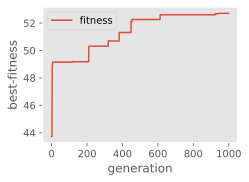

In [29]:
instance.run()

In [30]:
instance.bestfitnes

52.71231864157272

In [31]:
instance.bestfitness_individual

'DDATDGEATDIEDEGWDMEI'

In [33]:
instance.population

['DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDDKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'LDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
 'DDAKDGEATDIEDEGWDMEI',
